If you haven't gone through [Carl's Tutorial](https://github.com/carlshan/intro_to_machine_learning/blob/master/lessons/Reinforcement_Learning/RL_Tutorial.md), you may want to go through that and implement the hill-climbing policy before attempting this tutorial. I would not recommend implementing the policy gradient strategy unless you're interested in learning more about lower-level tensorflow. This tutorial uses keras, like the others this semester.

Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

# Installation
To be able to run the animation below, make sure you have the latest version of matplotlib, by running `pip3 install matplotlib --upgrade`

In [19]:
%matplotlib inline
import json
import numpy as np
import random
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

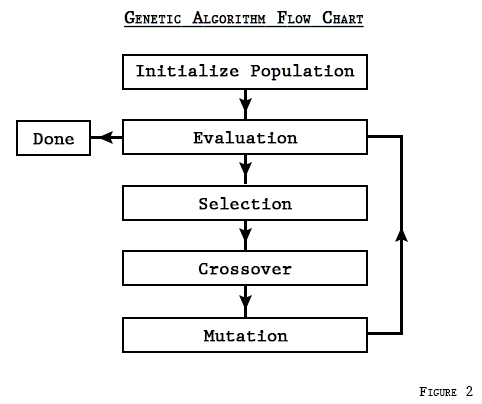

### Notes

#### Selection: 
evaluate the fitness of members of the current generation, then we select the subset with the best fitness values in order to act as parents for the next generation. In short, survival for the fittest.

#### Crossover: 
merge pairs from the selected parents to generate new offspring child solution. Crossover can happen in different forms, simplest form is the one-point crossover which splits the string representation of each solutions into two parts at the same position, then conctatnate the first part of one solution with the second part of the second one to form the offspring solution representation.

#### Mutation: 
In biology, mutation happens with low probability where a child can have a feature that was not inherited from the parents. Likewise, in genetic algorithm mutation step perturbs the offspring solution with very small probability (e.g. flipping one bit of the bitstring representation of the solution)

## Define the game environment and replay classes

In [20]:
class Catch(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_basket_center = 1
        self.max_basket_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves basket according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, basket_center = self.state
        # move the basket unless this would move it off the edge of the grid
        new_basket_center = min(max(self.min_basket_center, basket_center + movement), self.max_basket_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_basket_center])
        self.state = out
        
        return fruit_x, new_basket_center

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and basket and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, basket_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, basket_center-1:basket_center + 2] = 1  # draw 3-pixel basket
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was caught, -1 if it was dropped, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, basket_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - basket_center) <= 1:
                return 1 # it caught the fruit
            else:
                return -1 # it dropped the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        
        fruit_x, fruit_y, new_basket_center = self.state
        
        basket_x = new_basket_center - 1
        
        #defining obs by making x pos of paddle as 10s digit (grid_size = 10 rn) and adding fruit_x to ones digit
        current_obs = (basket_x)*self.grid_size + fruit_x
        
        #for next time: whenever observe is currently used, use observation[0], and for the current issue with array
        #in create_animation 113, use observation[1]
            
        return canvas.reshape((1, -1)), current_obs

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if game is over and False otherwise
        '''
        self._update_state(action)
        observation, _ = self.observe() #by convention, underscore signifies you won't use that var
        reward = self._get_reward()
        game_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, game_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            basket center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        basket_center = random.randint(self.min_basket_center, self.max_basket_center)
        self.state = np.asarray([fruit_x, fruit_y, basket_center])




### Notes for Applying the Game to Evolutionary Model

- total states: 1 for every pos of the paddle (gridSize - paddleSize+1) times every x value of the fruit (gridSize) times possible moves (3)
    - possible moves: left, stay, right
- Random Search:
    - b/c there are too many states, select a random set of them, and keep the ones that work the best
- Genetic Algorithm:
    -

##  Functions for creating, training, and visualizing the model

In [43]:
import time

# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 20
possible_actions = 3
paddle_size = 3
num_states = (grid_size-paddle_size+1)*(grid_size)*(possible_actions)



 



def run_episode(env, policy, episode_len=100):
    total_reward = 0
    #obs = env.reset()
    env.reset()
    canvas_observation, observation = env.observe() #don't need second var right now
    observations = []
    for t in range(episode_len):
        # env.render()
        canvas_observation, observation = env.observe()
        action = policy[observation]
        obs, reward, done = env.act(action)
        total_reward += reward
        if done:
            # print('Episode finished after {} timesteps.'.format(t+1))
            break
    return total_reward


def evaluate_policy(env, policy, n_episodes=100):
    total_rewards = 0.0
    for _ in range(n_episodes):
        total_rewards += run_episode(env, policy)
    return total_rewards / n_episodes

def gen_random_policy():
    return np.random.choice(possible_actions, size=((num_states)))

def crossover(policy1, policy2):
    new_policy = policy1.copy()
    for i in range(num_states):
        rand = np.random.uniform()
        if rand > 0.5:
            new_policy[i] = policy2[i]
    return new_policy

def mutation(policy, p=0.05):
    new_policy = policy.copy()
    for i in range(num_states):
        rand = np.random.uniform()
        if rand < p:
            new_policy[i] = np.random.choice(possible_actions)
    return new_policy

# each policy replaces the singular model
# the policies are creating a group of models (and selecting the best one) to solve the problem

def train_policy():
    n_policy = 100
    n_generations = 40
    start = time.time()
    policy_pop = [gen_random_policy() for _ in range(n_policy)]
    for idx in range(n_generations):
        policy_scores = [evaluate_policy(env, p) for p in policy_pop]
        #evaluate how well the policy is doing
        print('Generation %d : max score = %0.2f' %(idx+1, max(policy_scores)))
        policy_ranks = list(reversed(np.argsort(policy_scores)))
        elite_set = [policy_pop[x] for x in policy_ranks[:5]]
        select_probs = np.array(policy_scores) / np.sum(policy_scores)
        child_set = [crossover(
            policy_pop[np.random.choice(range(n_policy), p=select_probs)], 
            policy_pop[np.random.choice(range(n_policy), p=select_probs)])
            for _ in range(n_policy - 5)]
        mutated_list = [mutation(p) for p in child_set]
        policy_pop = elite_set
        policy_pop += mutated_list
    policy_score = [evaluate_policy(env, p) for p in policy_pop]
    best_policy = policy_pop[np.argmax(policy_score)]

    end = time.time()
    print('Best policy score = %0.2f. Time taken = %4.4f'
            %(np.max(policy_score), (end-start))) 
    return best_policy

def build_policy():
    # Define environment/game
    env = Catch(grid_size)
    
    return env


def create_animation(best_policy, env, num_games):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_games: integer, the number of games to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the games and collect all of the images for each observed state
    
    observations = []
    for _ in range(num_games):
        env.reset()
        canvas_observation, observation = env.observe()
        observations.append(canvas_observation)
        game_over = False
        while game_over == False:
            #q = model.predict(observation)
            #print (observation)
            action = best_policy[observation]
            
            # apply action, get rewards and new state
            canvas_observation, reward, game_over = env.act(action)
            canvas_observation, observation = env.observe()
            observations.append(canvas_observation)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    
    def animate(canvas_observation):
        image.set_array(canvas_observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Let's create our model and game environment and see how it does before training

In [44]:
env = build_policy()
rand_policy = gen_random_policy()

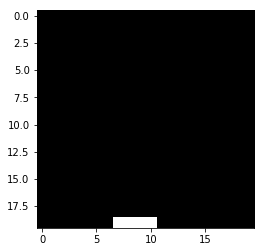

In [45]:
animation = create_animation(rand_policy, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

## Now train the model and see how much better it is at catching the fruit

Generation 1 : max score = -0.52
Generation 2 : max score = -0.40
Generation 3 : max score = -0.46
Generation 4 : max score = -0.52
Generation 5 : max score = -0.48
Generation 6 : max score = -0.50
Generation 7 : max score = -0.40
Generation 8 : max score = -0.44
Generation 9 : max score = -0.48
Generation 10 : max score = -0.50
Generation 11 : max score = -0.52
Generation 12 : max score = -0.40
Generation 13 : max score = -0.44
Generation 14 : max score = -0.44
Generation 15 : max score = -0.48
Generation 16 : max score = -0.44
Generation 17 : max score = -0.52
Generation 18 : max score = -0.50
Generation 19 : max score = -0.52
Generation 20 : max score = -0.48
Generation 21 : max score = -0.50
Generation 22 : max score = -0.46
Generation 23 : max score = -0.48
Generation 24 : max score = -0.50
Generation 25 : max score = -0.44
Generation 26 : max score = -0.52
Generation 27 : max score = -0.46
Generation 28 : max score = -0.44
Generation 29 : max score = -0.42
Generation 30 : max sco

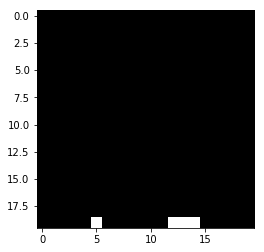

In [46]:
best_policy = train_policy()

#train_policy(best_policy, env, num_episodes=1000)
animation = create_animation(best_policy, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())